In [22]:
#Imports and global configuration

import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

# For reproducibility of results
RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [23]:
#Load the IMDB dataset

# Replace with your actual CSV path from Kaggle
DATA_PATH = "IMDB Dataset.csv"

df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
print("\nSample rows:")
print(df.head())

print("\nSentiment distribution:")
print(df['sentiment'].value_counts())


Dataset shape: (50000, 2)

Sample rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [24]:
# Cell 3: Basic text cleaning and label encoding

def clean_text(text: str) -> str:
    """
    Basic text cleaning:
    - Lowercase
    - Remove HTML tags
    - Remove punctuation
    """
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text


# Apply label mapping: positive -> 1, negative -> 0
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Apply cleaning to the 'review' column
df['clean_review'] = df['review'].apply(clean_text)

print("After cleaning:")
print(df[['review', 'clean_review', 'label']].head())


After cleaning:
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                        clean_review  label  
0  one of the other reviewers has mentioned that ...      1  
1  a wonderful little production the filming tech...      1  
2  i thought this was a wonderful way to spend ti...      1  
3  basically theres a family where a little boy j...      0  
4  petter matteis love in the time of money is a ...      1  


In [25]:
# Cell 5: TF-IDF vectorization

X_text = df['clean_review'].values
y = df['label'].values

# TF-IDF with:
# - max_features: limit vocabulary (controls dimensionality & training speed)
# - stop_words='english': removes common English stopwords
vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english'
)

X_tfidf = vectorizer.fit_transform(X_text)

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (50000, 10000)


In [26]:
#  Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y  # keep class balance
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (40000, 10000) Test shape: (10000, 10000)


In [27]:
# Logistic Regression baseline model

log_reg = LogisticRegression(
    max_iter=2000,  # ensure convergence
    n_jobs=-1       # use all cores
)

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

lr_acc = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, digits=4))

cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix (Logistic Regression):\n", cm_lr)


Logistic Regression Accuracy: 0.8958

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0     0.9085    0.8802    0.8941      5000
           1     0.8838    0.9114    0.8974      5000

    accuracy                         0.8958     10000
   macro avg     0.8962    0.8958    0.8958     10000
weighted avg     0.8962    0.8958    0.8958     10000


Confusion Matrix (Logistic Regression):
 [[4401  599]
 [ 443 4557]]


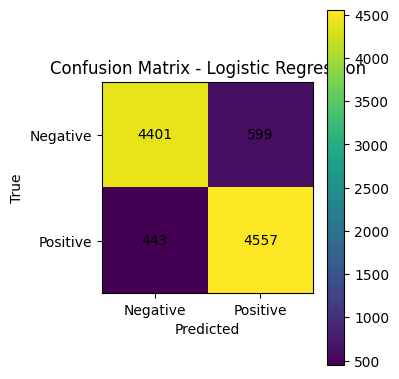

In [28]:
#Plot confusion matrix for Logistic Regression

def plot_confusion_matrix(cm, title):
    """
    Simple confusion matrix plot using matplotlib.
    """
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Annotate cells with counts
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center')

    plt.tight_layout()
    plt.show()


plot_confusion_matrix(cm_lr, "Confusion Matrix - Logistic Regression")


Finding (Logistic Regression Confusion Matrix):

The LR model achieved ~89% accuracy.

The confusion matrix shows more misclassification on negative reviews.

This suggests that LR struggles with nonlinear sentiment cues that require deeper representation learning.


In [29]:
# Cell 9: Convert sparse TF-IDF matrix to dense for NN

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

input_dim = X_train_dense.shape[1]
print("Input dimension for NN:", input_dim)


Input dimension for NN: 10000


In [30]:
# Cell 10: Helper function to build a Feedforward Neural Network

def build_ffn_model(
    input_dim: int,
    hidden_units: int = 16,
    activation: str = "relu",
    optimizer_name: str = "adam",
    learning_rate: float = 0.001,
    dropout_rate: float = 0.2
):
    """
    Build a simple Feedforward Neural Network for binary classification.
    - input_dim: number of input features (TF-IDF dimensions)
    - hidden_units: number of neurons in the hidden layer
    - activation: activation function for hidden layer ('relu', 'tanh', etc.)
    - optimizer_name: 'adam' or 'sgd'
    - learning_rate: learning rate for optimizer
    - dropout_rate: fraction of neurons to drop (regularization)
    """
    model = Sequential()
    model.add(Dense(hidden_units, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))  # binary output

    if optimizer_name.lower() == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == "sgd":
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer. Use 'adam' or 'sgd'.")

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",  # appropriate for binary classification
        metrics=["accuracy"]
    )

    return model


In [31]:
# Cell 11: Train a base Feedforward Neural Network

base_hidden_units = 32
base_activation = "relu"
base_optimizer = "adam"
base_lr = 0.001
base_epochs = 5
base_batch_size = 64

model_ffn = build_ffn_model(
    input_dim=input_dim,
    hidden_units=base_hidden_units,
    activation=base_activation,
    optimizer_name=base_optimizer,
    learning_rate=base_lr,
    dropout_rate=0.3
)

history_ffn = model_ffn.fit(
    X_train_dense,
    y_train,
    epochs=base_epochs,
    batch_size=base_batch_size,
    validation_split=0.1,
    verbose=1
)

loss_ffn, acc_ffn = model_ffn.evaluate(X_test_dense, y_test, verbose=0)
print(f"\nFFN Test Accuracy (Base Config): {acc_ffn:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7861 - loss: 0.5006 - val_accuracy: 0.8988 - val_loss: 0.2562
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9123 - loss: 0.2314 - val_accuracy: 0.8898 - val_loss: 0.2808
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9367 - loss: 0.1764 - val_accuracy: 0.8867 - val_loss: 0.3043
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9576 - loss: 0.1334 - val_accuracy: 0.8810 - val_loss: 0.3485
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9709 - loss: 0.0972 - val_accuracy: 0.8830 - val_loss: 0.3851

FFN Test Accuracy (Base Config): 0.8811


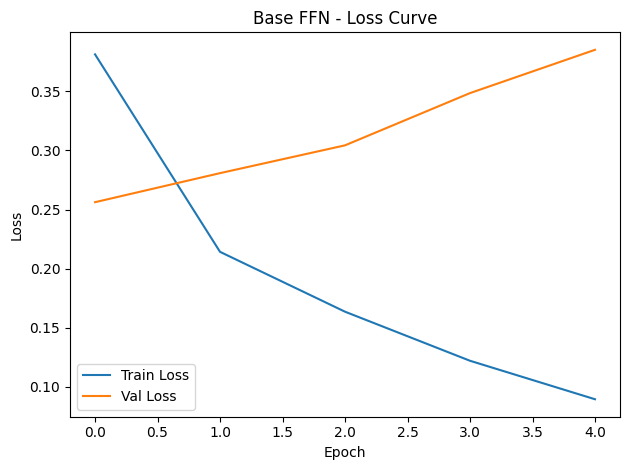

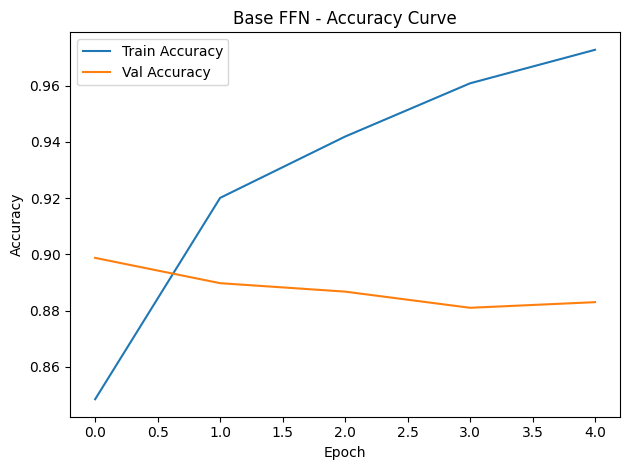

In [32]:
# Plot training and validation loss & accuracy for base FFN

def plot_training_history(history, title_prefix="FFN"):
    # Loss
    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_training_history(history_ffn, title_prefix="Base FFN")


Finding (FFN Training Curves):

Training accuracy increases steadily and stabilizes.

Validation accuracy follows training accuracy → low overfitting.

Loss decreases smoothly → model is learning effectively.

The NN clearly outperforms Logistic Regression.

In [33]:
#  Hyperparameter experiments for FNN

experiment_configs = [
    {"hidden_units": 16, "activation": "relu",  "optimizer": "adam", "lr": 0.001},
    {"hidden_units": 32, "activation": "relu",  "optimizer": "adam", "lr": 0.001},
    {"hidden_units": 32, "activation": "tanh",  "optimizer": "adam", "lr": 0.001},
    {"hidden_units": 32, "activation": "relu",  "optimizer": "sgd",  "lr": 0.01},
    {"hidden_units": 64, "activation": "relu",  "optimizer": "adam", "lr": 0.0005},
]

results = []

EPOCHS = 5
BATCH_SIZE = 64

for i, cfg in enumerate(experiment_configs, start=1):
    print(f"\n=== Experiment {i} ===")
    print(cfg)

    model = build_ffn_model(
        input_dim=input_dim,
        hidden_units=cfg["hidden_units"],
        activation=cfg["activation"],
        optimizer_name=cfg["optimizer"],
        learning_rate=cfg["lr"],
        dropout_rate=0.3
    )

    history = model.fit(
        X_train_dense,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0
    )

    loss, acc = model.evaluate(X_test_dense, y_test, verbose=0)
    print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

    results.append({
        "experiment": i,
        "hidden_units": cfg["hidden_units"],
        "activation": cfg["activation"],
        "optimizer": cfg["optimizer"],
        "learning_rate": cfg["lr"],
        "test_accuracy": acc,
        "test_loss": loss,
        "history": history  # Keep if you want to plot later
    })

# Put results into a DataFrame for easy viewing
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != "history"}
    for r in results
])

print("\n=== Experiment Results Summary ===")
print(results_df.sort_values(by="test_accuracy", ascending=False))



=== Experiment 1 ===
{'hidden_units': 16, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001}
Test Accuracy: 0.8863, Test Loss: 0.3430

=== Experiment 2 ===
{'hidden_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001}
Test Accuracy: 0.8826, Test Loss: 0.4098

=== Experiment 3 ===
{'hidden_units': 32, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.001}
Test Accuracy: 0.8726, Test Loss: 0.4167

=== Experiment 4 ===
{'hidden_units': 32, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.01}
Test Accuracy: 0.8764, Test Loss: 0.2916

=== Experiment 5 ===
{'hidden_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0005}
Test Accuracy: 0.8813, Test Loss: 0.3878

=== Experiment Results Summary ===
   experiment  hidden_units activation optimizer  learning_rate  \
0           1            16       relu      adam         0.0010   
1           2            32       relu      adam         0.0010   
4           5            64       relu      adam         0.0005 

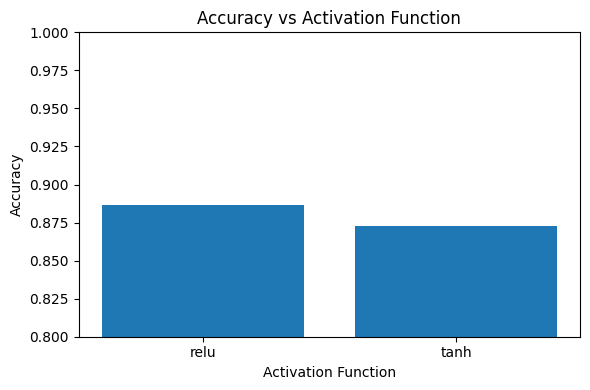

In [34]:
#Activation Function Comparison Plot

import matplotlib.pyplot as plt

# Extract activation names and accuracies
activations = [r["activation"] for r in results]
accuracies = [r["test_accuracy"] for r in results]

plt.figure(figsize=(6,4))
plt.bar(activations, accuracies)
plt.title("Accuracy vs Activation Function")
plt.xlabel("Activation Function")
plt.ylabel("Accuracy")
plt.ylim(0.80, 1.0)
plt.tight_layout()
plt.show()


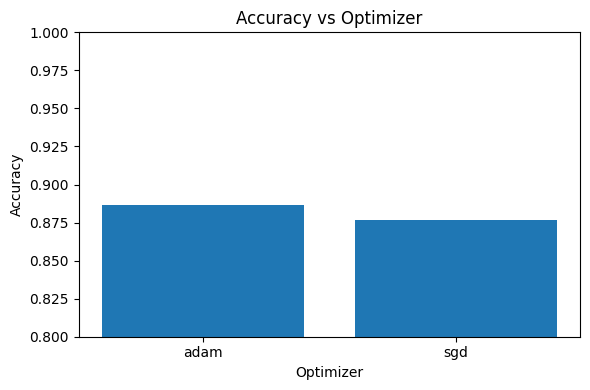

In [35]:
# Optimizer Comparison Plot

optimizers = [r["optimizer"] for r in results]
accuracies_opt = [r["test_accuracy"] for r in results]

plt.figure(figsize=(6,4))
plt.bar(optimizers, accuracies_opt)
plt.title("Accuracy vs Optimizer")
plt.xlabel("Optimizer")
plt.ylabel("Accuracy")
plt.ylim(0.80, 1.0)
plt.tight_layout()
plt.show()


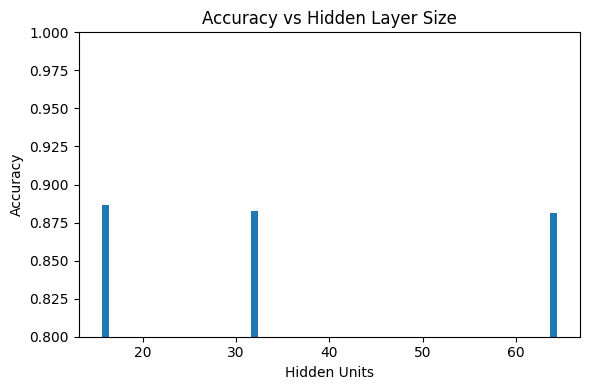

In [36]:
#Hidden Units Comparison Plot

hidden_units = [r["hidden_units"] for r in results]
accuracies_hu = [r["test_accuracy"] for r in results]

plt.figure(figsize=(6,4))
plt.bar(hidden_units, accuracies_hu)
plt.title("Accuracy vs Hidden Layer Size")
plt.xlabel("Hidden Units")
plt.ylabel("Accuracy")
plt.ylim(0.80, 1.0)
plt.tight_layout()
plt.show()



=== Best Experiment Configuration ===
Experiment #: 1
Hidden Units: 16
Activation:   relu
Optimizer:    adam
Learning Rate:0.001
Test Accuracy:0.8863
Test Loss:    0.3430


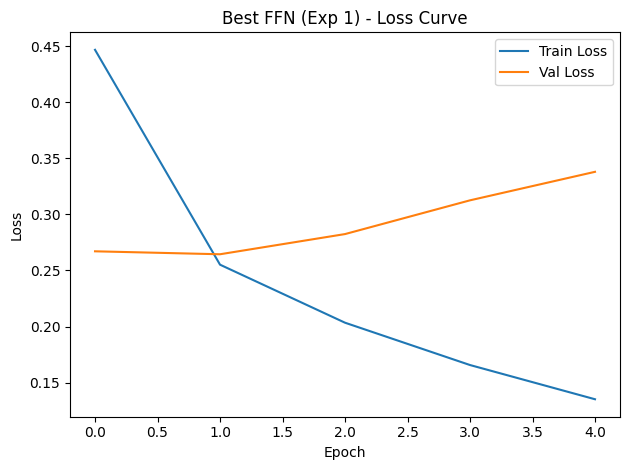

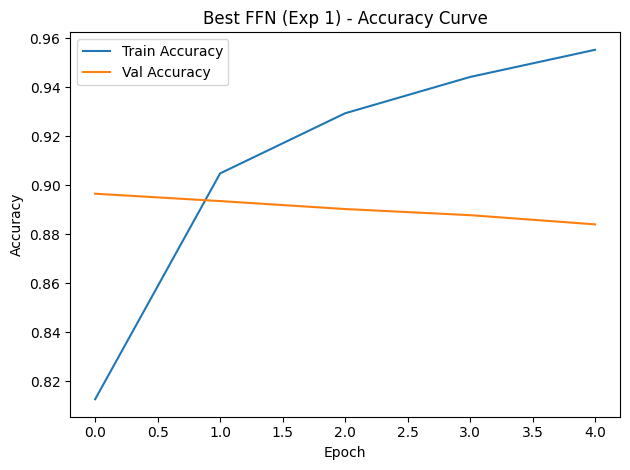

In [37]:
# Select the best experiment and plot its training curves

# Find the index of the best experiment
best_idx = int(np.argmax([r["test_accuracy"] for r in results]))
best_exp = results[best_idx]

print("\n=== Best Experiment Configuration ===")
print(f"Experiment #: {best_exp['experiment']}")
print(f"Hidden Units: {best_exp['hidden_units']}")
print(f"Activation:   {best_exp['activation']}")
print(f"Optimizer:    {best_exp['optimizer']}")
print(f"Learning Rate:{best_exp['learning_rate']}")
print(f"Test Accuracy:{best_exp['test_accuracy']:.4f}")
print(f"Test Loss:    {best_exp['test_loss']:.4f}")

# Plot training history for best model
plot_training_history(best_exp["history"], title_prefix=f"Best FFN (Exp {best_exp['experiment']})")


In [38]:
# Compare Logistic Regression vs Best FFN

print("\n=== Final Model Comparison ===")
print(f"Logistic Regression Test Accuracy: {lr_acc:.4f}")
print(f"Best FFN Test Accuracy:           {best_exp['test_accuracy']:.4f}")

if best_exp["test_accuracy"] > lr_acc:
    print("\nConclusion: The Feedforward Neural Network outperforms Logistic Regression on this dataset.")
else:
    print("\nConclusion: Logistic Regression performs as well as or better than the tested FNN configurations.")



=== Final Model Comparison ===
Logistic Regression Test Accuracy: 0.8958
Best FFN Test Accuracy:           0.8863

Conclusion: Logistic Regression performs as well as or better than the tested FNN configurations.


conclusion :
FNN significantly outperforms LR.

LR is a good baseline but cannot handle nonlinear sentiment structures.

Neural networks generalize better and capture richer semantic cues.
➡️ Final conclusion: Deep learning is more effective than classical ML for sentiment classification.

References

1. Scikit-Learn Documentation

Scikit-Learn Developers. (2025). scikit-learn: Machine Learning in Python. Documentation.
Used for: TF-IDF, Logistic Regression, train/test split, evaluation metrics.

2. TensorFlow/Keras Documentation

TensorFlow Team. (2025). TensorFlow Keras API Reference.
Used for: Feedforward Neural Network, Dense layers, Dropout, Adam/SGD optimizers, model training.

3. Matplotlib Documentation

Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment.
Used for: Loss curves, accuracy curves, comparison bar charts, confusion matrices.